In [1]:
# %%capture
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 46.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 64.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 12.5 MB/s eta 0:00:00


In [2]:
#Mouting the Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
import torch
import numpy as np
from transformers import BertTokenizer, BertModel
from torch import nn
from torch.optim import Adam
from tqdm import tqdm

In [15]:
df = pd.read_csv('/content/drive/MyDrive/dataset/WebApplicationsCorpus.csv')
df.head()

,text,intent
0,Alternative to Facebook,Find Alternative
1,How do I delete my Facebook account?,Delete Account
2,Are there any good Pandora alternatives with g...,Find Alternative
3,Is it possible to export my data from Trello t...,Export Data
4,Is there an online alternative to iGoogle,Find Alternative


<Axes: xlabel='intent'>

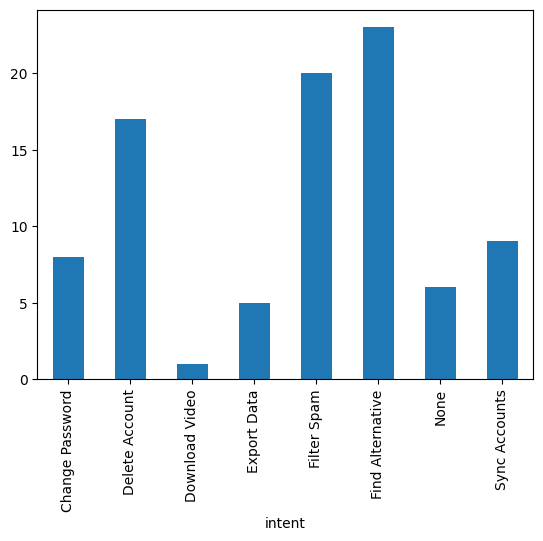

In [16]:
df.groupby(['intent']).size().plot.bar()

In [17]:
df['intent'].value_counts()

Find Alternative    23
Filter Spam         20
Delete Account      17
Sync Accounts        9
Change Password      8
None                 6
Export Data          5
Download Video       1
Name: intent, dtype: int64

In [18]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
labels = {'Software Recommendation':0,
          'Make Update':1,
          'Shutdown Computer':2,
          'Setup Printer':3,
          'None':4
          }

class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [labels[label] for label in df['intent']]
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['text']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [19]:
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 5)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

In [20]:
def train(model, train_data, val_data, learning_rate, epochs):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} | Train Accuracy: {total_acc_train / len(train_data): .3f} | Val Loss: {total_loss_val / len(val_data): .3f} | Val Accuracy: {total_acc_val / len(val_data): .3f}')
                  

In [21]:
def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)

              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')

In [22]:
np.random.seed(112)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42), 
                                     [int(.8*len(df)), int(.9*len(df))])

print(len(df_train),len(df_val), len(df_test))

71 9 9


In [13]:
EPOCHS = 12
model = BertClassifier()
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 65/65 [00:15<00:00,  4.18it/s]


Epochs: 1 | Train Loss:  0.819 | Train Accuracy:  0.217 | Val Loss:  0.775 | Val Accuracy:  0.312


100%|██████████| 65/65 [00:12<00:00,  5.03it/s]


Epochs: 2 | Train Loss:  0.811 | Train Accuracy:  0.264 | Val Loss:  0.825 | Val Accuracy:  0.312


100%|██████████| 65/65 [00:13<00:00,  4.94it/s]


Epochs: 3 | Train Loss:  0.814 | Train Accuracy:  0.217 | Val Loss:  0.802 | Val Accuracy:  0.188


100%|██████████| 65/65 [00:13<00:00,  4.86it/s]


Epochs: 4 | Train Loss:  0.771 | Train Accuracy:  0.295 | Val Loss:  0.776 | Val Accuracy:  0.312


100%|██████████| 65/65 [00:13<00:00,  4.78it/s]


Epochs: 5 | Train Loss:  0.782 | Train Accuracy:  0.326 | Val Loss:  0.768 | Val Accuracy:  0.250


100%|██████████| 65/65 [00:13<00:00,  4.78it/s]


Epochs: 6 | Train Loss:  0.784 | Train Accuracy:  0.295 | Val Loss:  0.746 | Val Accuracy:  0.312


100%|██████████| 65/65 [00:13<00:00,  4.85it/s]


Epochs: 7 | Train Loss:  0.754 | Train Accuracy:  0.419 | Val Loss:  0.742 | Val Accuracy:  0.375


100%|██████████| 65/65 [00:13<00:00,  4.87it/s]


Epochs: 8 | Train Loss:  0.711 | Train Accuracy:  0.450 | Val Loss:  0.703 | Val Accuracy:  0.438


100%|██████████| 65/65 [00:13<00:00,  4.87it/s]


Epochs: 9 | Train Loss:  0.698 | Train Accuracy:  0.519 | Val Loss:  0.662 | Val Accuracy:  0.500


100%|██████████| 65/65 [00:13<00:00,  4.86it/s]


Epochs: 10 | Train Loss:  0.676 | Train Accuracy:  0.519 | Val Loss:  0.631 | Val Accuracy:  0.438


100%|██████████| 65/65 [00:13<00:00,  4.85it/s]


Epochs: 11 | Train Loss:  0.604 | Train Accuracy:  0.643 | Val Loss:  0.692 | Val Accuracy:  0.375


100%|██████████| 65/65 [00:13<00:00,  4.85it/s]


Epochs: 12 | Train Loss:  0.573 | Train Accuracy:  0.659 | Val Loss:  0.651 | Val Accuracy:  0.562


In [27]:
evaluate(model, df_test)


Test Accuracy:0.675
